In [13]:
from model import UNET
from util import *
import tensorflow as tf
import numpy as np


import os
import tarfile

In [14]:
dataPath = os.path.join(".","Data","Images")
maskPath = os.path.join(".","Data","Segmentation")
dataType = "*.png"

SEED = 42
DATA_SPLIT = 0.8

OPTIMIZER = "adam"
LOSS = "binary_crossentropy"
METRICS = ["accuracy"]

In [15]:
if not os.path.isdir(dataPath) or not os.path.isdir(maskPath):
    #untar the data if it hasnt been
    print("UNZIPPING DATA")
    with tarfile.open(os.path.join(".","Data","data.tar.gz")) as file:
        file.extractall(os.path.join(".","Data"))


Tensor("args_0:0", shape=(), dtype=string)


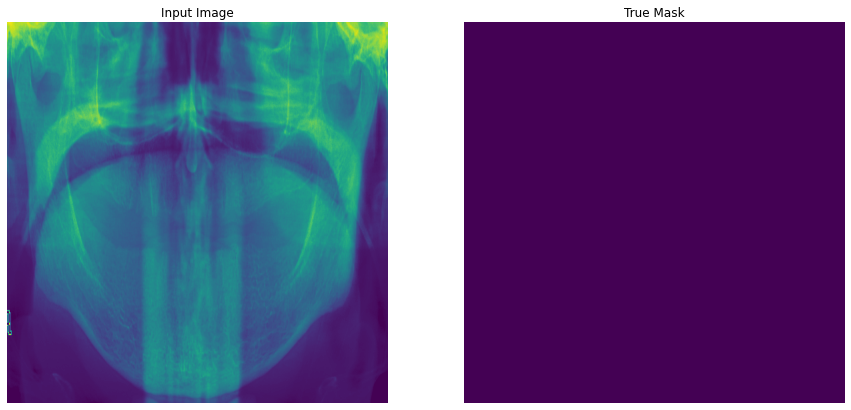

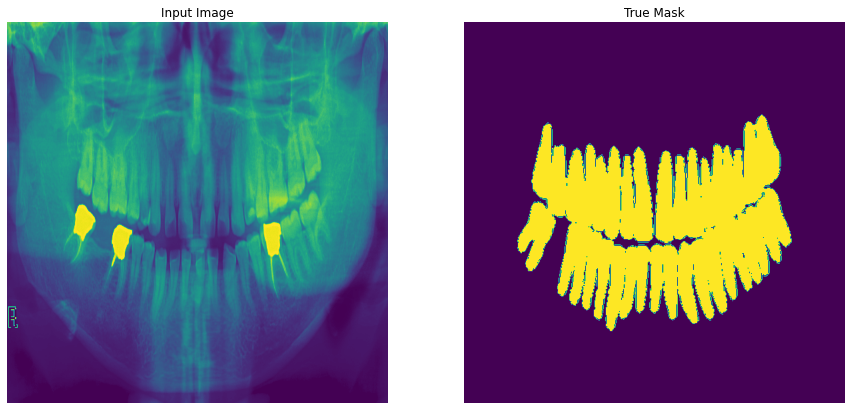

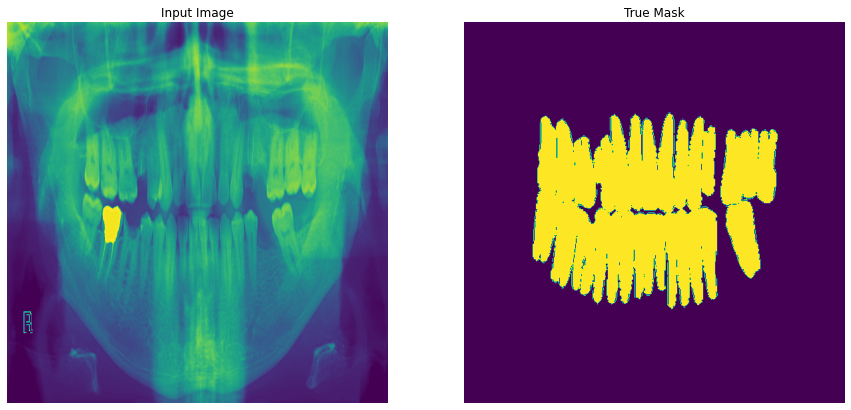

In [16]:
# LOAD DATASET AS TF DATASET
dataset = generate_dataset(dataPath, dataType, seed=SEED, img_shape = [572,572])
for element in dataset.take(3):
    image_shape = element["image"].numpy().shape
    display_mask_image([element["image"],element["mask"]])
    
split_point = np.ceil(len(dataset)*DATA_SPLIT)
train = dataset.take(split_point).map(lambda x: (x["image"],x["mask"]))
test = dataset.skip(split_point).map(lambda x: (x["image"],x["mask"]))


In [17]:
print("IMAGE SHAPE -> {shp}".format(shp=(image_shape)))
model = UNET(input_shape = image_shape)
model.summary()
model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

IMAGE SHAPE -> (572, 572, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 572, 572, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 570, 570, 1)  10          ['input_3[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 568, 568, 64  640         ['conv2d_33[0][0]']              
                                )                                                                 
                                                               

In [18]:
#for some reason, passing the dataset directly into the model is giving me all sorts of trouble, let us instead
xtrain = np.array([x[0] for x in train])
ytrain = np.array([x[1] for x in train])

In [19]:
model.fit(xtrain,ytrain,batch_size=8,epochs=150,verbose=1)

Epoch 1/150


ValueError: in user code:

    File "/Users/akurlej/miniforge3/envs/dental_ML/lib/python3.10/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/akurlej/miniforge3/envs/dental_ML/lib/python3.10/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/akurlej/miniforge3/envs/dental_ML/lib/python3.10/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/akurlej/miniforge3/envs/dental_ML/lib/python3.10/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/Users/akurlej/miniforge3/envs/dental_ML/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/akurlej/miniforge3/envs/dental_ML/lib/python3.10/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/akurlej/miniforge3/envs/dental_ML/lib/python3.10/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/akurlej/miniforge3/envs/dental_ML/lib/python3.10/site-packages/keras/losses.py", line 1807, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/akurlej/miniforge3/envs/dental_ML/lib/python3.10/site-packages/keras/backend.py", line 5173, in binary_crossentropy
        bce = target * tf.math.log(output + epsilon())

    ValueError: Dimensions must be equal, but are 572 and 388 for '{{node binary_crossentropy/mul}} = Mul[T=DT_FLOAT](binary_crossentropy/Cast, binary_crossentropy/Log)' with input shapes: [?,572,572,1], [?,388,388,2].
